In [7]:
import numpy as np
from LinApp_Deriv import LinApp_Deriv
from LinApp_Solve import LinApp_Solve
from numba import jit
import scipy.optimize as opt
import matplotlib.pyplot as plt
import time
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import rouwen as rw
import scipy.stats as st

## Exercise 1

We are given the functional forms for the matricies $F,G,H,L,M$ and $N$ in the notes for the Brock & Mirman model. We must first find the steady-state value for $\overline{K}$, which we found in Pset 1 to be $A^{1-\alpha} = (\alpha \cdot \beta)^{1-\alpha}$. The analytical solutions then follow:

In [8]:
alpha = 0.35
beta = 0.98
rho = 0.95
sigma = 0.02

kbar = ((alpha*beta)**(1/(1-alpha)))
grid = np.linspace(0.5*kbar,1.5*kbar,25)
step = 10 * sigma/25
pi, zgrid = rw.rouwen(rho, 0, step, 25)
print(kbar)

0.1927826194504225


In [9]:
F = (alpha*kbar**(alpha-1))/(kbar**alpha - kbar)
G = -(((alpha*kbar**(alpha-1))*(alpha + kbar**(alpha-1)))/(kbar**alpha - kbar))
H = ((alpha**2)*(kbar**(2*(alpha-1))))/(kbar**alpha - kbar)
L = -((alpha*(kbar**(2*(alpha-1))))/(kbar**alpha - kbar))
M = ((alpha**2)*(kbar**(2*(alpha-1))))/(kbar**alpha - kbar)
N = rho*1

P = (-G - np.sqrt(G**2 - 4*F*H))/(2*F)
Q = kbar #-((L*N + M)/(F*N + F*P + G))
# There was an issue with derivations in the notes; I replaced the Sylvester equation with what
# we believed it should be. Will revisit shortly.

optK = np.empty((len(grid), len(zgrid)))
for i in range(len(grid)):
    optK[i,:] =  (P*(grid[i] - kbar) + Q*(zgrid - 0)) + kbar

print(F,G,H,L,M,N)
print("P:",P)
print("Q:",Q)

2.763343017362853 -9.023563692703393 2.8197377728192374 -8.056393636626394 2.8197377728192374 0.95
P: 0.35
Q: 0.1927826194504225


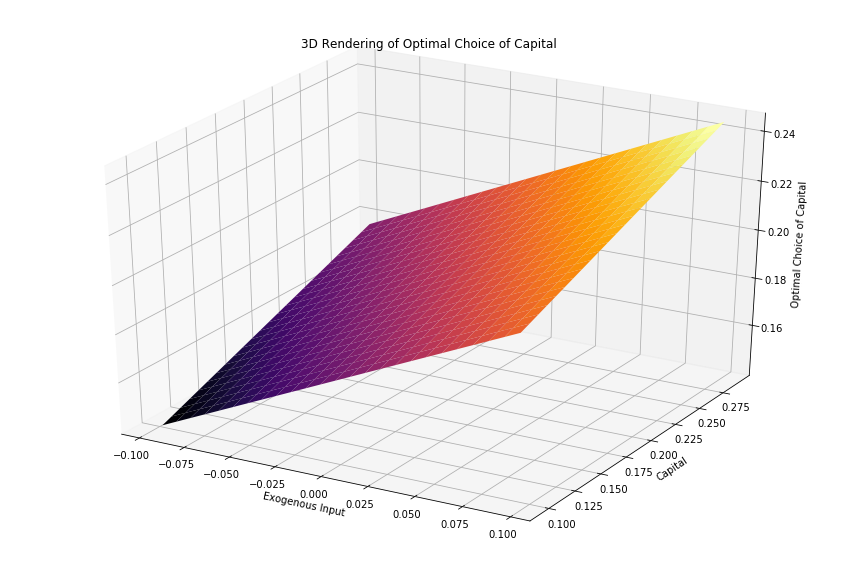

In [10]:
fig = plt.figure(figsize=(15, 10))
Z,K = np.meshgrid(grid, zgrid)
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(K,Z, optK, rstride=1, cstride=1, cmap=cm.inferno)
ax.set_xlabel('Exogenous Input')
ax.set_ylabel('Capital')
ax.set_zlabel('Optimal Choice of Capital')
ax.set_title('3D Rendering of Optimal Choice of Capital')
plt.show()

We now attempt to complete the same task, but combining the graph with the policy function found in the previous problem, and that found analytically:

In [11]:
optKiter = np.loadtxt('prob8policy.txt', delimiter=',')
optKorig = np.empty((len(grid),len(zgrid)))
for i in range(len(grid)):
    for j in range(len(zgrid)):
        optKorig[i, j] = alpha*beta*grid[i]**alpha*np.exp(zgrid[j])

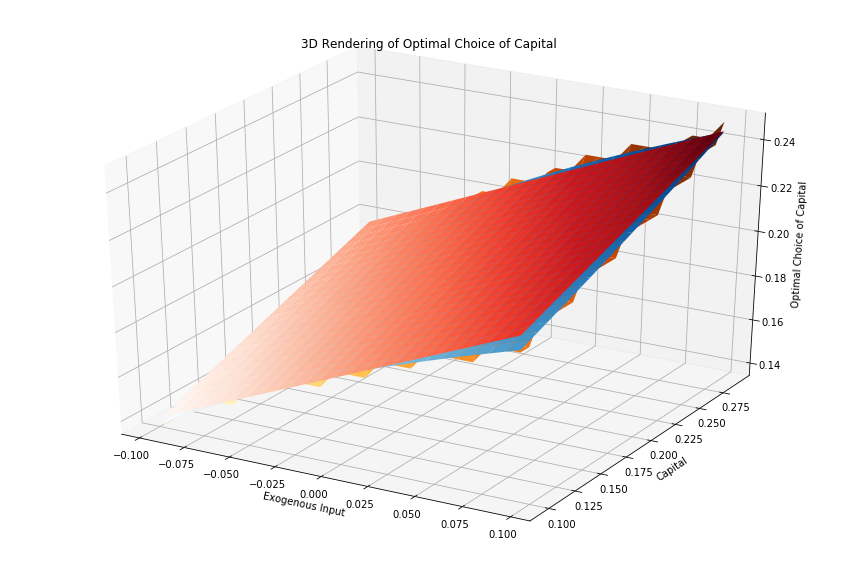

In [12]:
fig = plt.figure(figsize=(15, 10))
Z,K = np.meshgrid(grid, zgrid)
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(K,Z, optK, rstride=1, cstride=1, cmap=cm.Reds)
ax.plot_surface(K,Z, optKorig, rstride=1, cstride=1, cmap=cm.Blues)
ax.plot_surface(K,Z, optKiter, rstride=1, cstride=1, cmap=cm.YlOrBr)
ax.set_xlabel('Exogenous Input')
ax.set_ylabel('Capital')
ax.set_zlabel('Optimal Choice of Capital')
ax.set_title('3D Rendering of Optimal Choice of Capital')
plt.show()

## Exercise 2

We now seek to complete the same exercise, but for $k = ln(K)$. This time, we bypass manual calculation and use the included application:

In [13]:
params_2 = (alpha, beta, rho, sigma)
Theta  = np.array([kbar, kbar, kbar, 0., 0.])

[A, B, C, D, F, G, H, J, K, L, M, W, T] = LinApp_Deriv(rw.Modeldyn, params_2, Theta, 1, 0, 1, logX=True)
N = rho

print(F,G,H,L,M,N)
P,Q,U,R,S,V = LinApp_Solve(A,B,C,D,F,G,H,J,K,L,M,W,T,N,0,Sylv=1)
print("P:",P)
print("Q:",Q)

optK2 = np.empty((len(grid), len(zgrid)))
for i in range(len(grid)):
    for j in range(len(zgrid)):
        optK2[i,j] =  (P[0]*((grid[i] - kbar) / kbar) + Q[0]*zgrid[j])*kbar + kbar

[[-1.41380536]] [[ 4.61671341]] [[-1.44265853]] [[ 1.41380536]] [[-4.12188152]] 0.95
Using Sylvester equation solver...
P: [[ 0.35]]
Q: [[ 1.]]


We now graph our results:

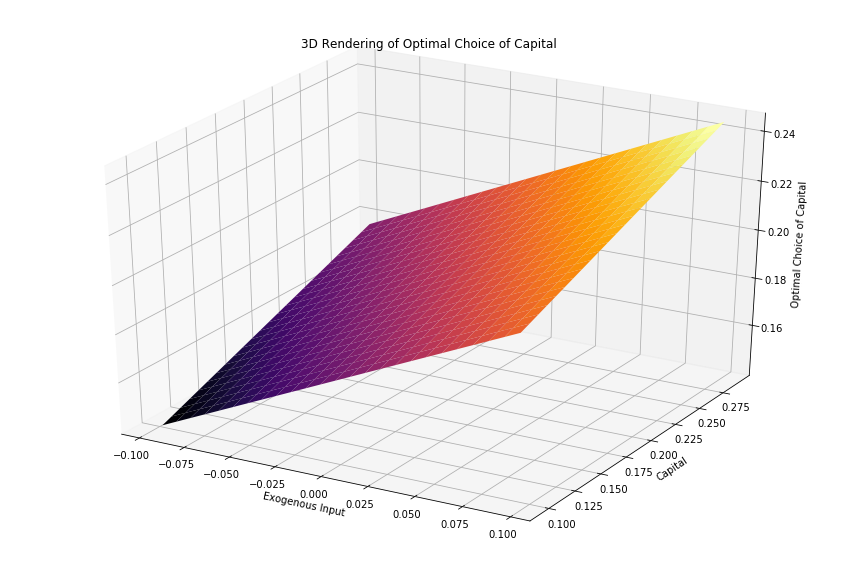

In [14]:
fig = plt.figure(figsize=(15, 10))
Z,K = np.meshgrid(grid, zgrid)
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(K,Z, optK2, rstride=1, cstride=1, cmap=cm.inferno)
ax.set_xlabel('Exogenous Input')
ax.set_ylabel('Capital')
ax.set_zlabel('Optimal Choice of Capital')
ax.set_title('3D Rendering of Optimal Choice of Capital')
plt.show()

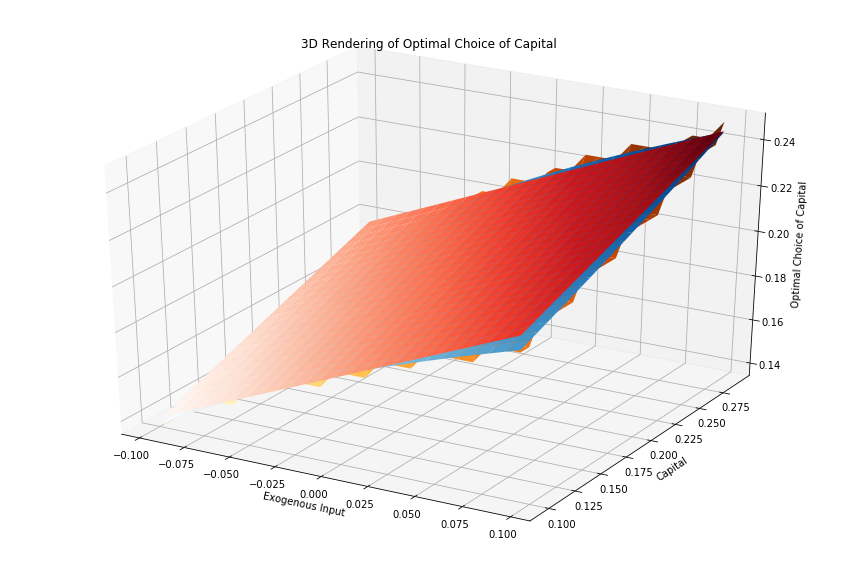

In [15]:
fig = plt.figure(figsize=(15, 10))
Z,K = np.meshgrid(grid, zgrid)
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(K,Z, optK2, rstride=1, cstride=1, cmap=cm.Reds)
ax.plot_surface(K,Z, optKorig, rstride=1, cstride=1, cmap=cm.Blues)
ax.plot_surface(K,Z, optKiter, rstride=1, cstride=1, cmap=cm.YlOrBr)
ax.set_xlabel('Exogenous Input')
ax.set_ylabel('Capital')
ax.set_zlabel('Optimal Choice of Capital')
ax.set_title('3D Rendering of Optimal Choice of Capital')
plt.show()

## Problem 3

We have:
\begin{equation}
\begin{split}
E_t\big[ FX_{t+1} + GX_t + HX_{t-1} + LZ_{t+1} + MZ_t \big] =& \ 0 \\
E_t\big[ F[PX_t + QZ_{t_1}] + GX_t + HX_{t-1} + LZ_{t+1} + MZ_t \big] =& \ 0 \\
E_t\Big[ F\big[P[PX_{t-1} + QZ_t] + QZ_{t-1}\big] + G\big[PX_{t-1} + QZ_t\big] + HX_{t-1} + LZ_{t+1} + MZ_t \Big] =& \ 0 \\
E_t\Big[ F\big[P[PX_{t-1} + QZ_t] + QZ_{t-1}\big] + G\big[PX_{t-1} + QZ_t\big] + HX_{t-1} + L\big[ NZ_{t} + \epsilon_t \big] + MZ_t \Big] =& \ 0 \\
E_t\big[ FP^2X_{t-1} + FPQZ_t + FQZ_{t-1} + GPX_{t-1} + GQZ_t + HX_{t-1} + LNZ_{t} + L\epsilon_t + MZ_t \big] =& \ 0 \\
E_t\Big[ \big[(FP+G)P + H\big]X_{t-1} + \big[ (FQ+L)N + (FP+G)Q + M\big]Z_t +L\epsilon_t \Big] =& \ 0 \\
E_t\Big[ \big[(FP+G)P + H\big]X_{t-1} + \big[ (FQ+L)N + (FP+G)Q + M\big]Z_t \Big] =& \ 0 \\
\end{split}
\end{equation}

## Problem 4

We have the following functional forms for a sample model:
\begin{equation}
\begin{split}
u(c_t,l_t) =& \ \frac{c_t^{1-\gamma} - 1}{1 - \gamma} + a \cdot \frac{(1-l_t)^{1-\zeta} -1}{1-\zeta} \\
F(K_t,L_t,z_t) =& \ K_t^{\alpha}(L_te^{z_t})^{1-\alpha}
\end{split}
\end{equation}
These can be plugged into the characterizing equations as follows:
\begin{equation}
\begin{split}
c_t =& \ (1-\tau)\big[ w_tl_t+(r_t-\delta)k_t \big]+k_t+T_t-k_{t+1} \\
\frac{1}{c_t^{\gamma}} =& \ \beta E_t \bigg[ \frac{1}{c^{\gamma}_{t+1}} [(r_{t+1}-\delta)(1-\tau)+1] \bigg] \\
\frac{a}{(1-l_t)^{\zeta}} =& \ \frac{w_t(1-\tau)}{c^{\gamma}} \\
r_t =& \ \alpha k_t^{\alpha -1} (l_te^{z-t})^{1-\alpha}  \\
w_t =& \  \frac{(1 - \alpha)k^{\alpha}e^{(1-\alpha)z_t}}{l_t^{\alpha}}\\
\tau[w_tl_t + (r_t-\delta)k_t] =& \ T_t \\
z_t =& \ (1-\rho_z)\overline{z} + \rho_zz_{t-1}+\epsilon_t^z
\end{split}
\end{equation}

The following are the steady-state equations:
\begin{equation}
\begin{split}
\overline{c} =& \ (1-\tau)\big[ \overline{w}+(\overline{r}-\delta)\overline{k} \big] + \overline{T}\\
\frac{1}{\overline{c}^{\gamma}} =& \ \beta E_t \bigg[ \frac{1}{\overline{c}^{\gamma}} [(\overline{r}-\delta)(1-\tau)+1] \bigg] \\
\frac{a}{(1-\overline{l})^{\zeta}} =& \ \frac{\overline{w}(1-\tau)}{\overline{c}^{\gamma}} \\
\overline{r} =& \ \alpha \overline{k}^{\alpha -1} (\overline{l}e^{\overline{z}})^{1-\alpha}  \\
\overline{w} =& \  \frac{(1 - \alpha)\overline{k}^{\alpha}e^{(1-\alpha)\overline{z}}}{\overline{l}^{\alpha}}\\
\tau[\overline{w} + (\overline{r}-\delta)\overline{k}] =& \ \overline{T} \\
\end{split}
\end{equation}
With these, we are able to solve for the long-run capital value using VFI:

In [16]:
alpha = 0.4
beta = 0.98
gamma = 2.5
delta = 0.10
zeta = 1.5
tau = 0.05
rho = 0.95
a = 0.5
zbar = 0

In [17]:
paramss = np.array([gamma,zeta,beta,alpha,a,delta,tau,zbar])

def rate(k,l,params):
    gamma,zeta,beta,alpha,a,delta,tau,zbar = params
    return alpha*(l**(1-alpha))*(k**(alpha-1))

def wage(k,l,params):
    gamma,zeta,beta,alpha,a,delta,tau,zbar = params
    return (1-alpha)*(l**(-alpha))*(k**(alpha))

def consumption(k,l,w,r,params):
    gamma,zeta,beta,alpha,a,delta,tau,zbar = params
    return w*l + (r-delta)*k

def prob4_error(V, params):
    gamma,zeta,beta,alpha,a,delta,tau,zbar = params
    k,l = V[0],V[1]
    r = rate(k,l,params)
    w = wage(k,l,params)
    c = consumption(k,l,w,r,params)
    error1 = (1/(c**gamma)) - beta*((1/(c**gamma))*((r-delta)*(1-tau)+1))
    error2 = ((w*(1-tau))/(c**gamma)) - (a/((1-l)**zeta))
    error  = np.array([error1,error2])
    return error

def transfer(k,l,w,r,params):
    gamma,zeta,beta,alpha,a,delta,tau,zbar = params
    return tau*(w + (r-delta)*k)

def investment(k,l,params):
    gamma,zeta,beta,alpha,a,delta,tau,zbar = params
    return delta*k

def outputs(k,l,params):
    gamma,zeta,beta,alpha,a,delta,tau,zbar = params
    return (k**alpha)*(l**(1-alpha))

result_prob4 = opt.fsolve(prob4_error,np.array([1,0.8]),args=(paramss))
print("Iterative Solution (k,l):",result_prob4)

Iterative Solution (k,l): [ 4.22522903  0.57979145]


In [18]:
kbar,lbar = result_prob4[0],result_prob4[1]
rbar,wbar = rate(kbar,lbar,paramss),wage(kbar,lbar,paramss)

print("Steady-State Capital           :", kbar)
print("Steady-State Labor             :", lbar)
print("Steady-State Interest Rate     :", rbar)
print("Steady-State Wage              :", wbar)
cbar = consumption(kbar,lbar,wbar,rbar,paramss)
Tbar = transfer(kbar,lbar,wbar,rbar,paramss)
Ibar = investment(kbar,lbar,paramss)
Obar = outputs(kbar,lbar,paramss)
print("Steady-State Consumption       :", cbar)
print("Steady-State Transfer Payments :", Tbar)
print("Steady-State Investment        :", Ibar)
print("Steady-State Output            :", Obar)

Steady-State Capital           : 4.22522902678
Steady-State Labor             : 0.579791453167
Steady-State Interest Rate     : 0.121482277121
Steady-State Wage              : 1.32795276835
Steady-State Consumption       : 0.860703206154
Steady-State Transfer Payments : 0.0709360154603
Steady-State Investment        : 0.422522902678
Steady-State Output            : 1.28322610883


## Exercise 5

We now seek to find the rates of change (derivatives) of each outcome steady-state variable given a change in each parameter. We carry over results from Exercise 4:

In [19]:
params_names = np.array(["gamma","zeta","beta","alpha","a","delta","tau","zbar"])
h = 0.0001

for i in range(len(paramss)):
    params_i = np.copy(paramss)
    params_i[i] = params_i[i]+h
    r_iter = opt.fsolve(prob4_error,np.array([1,0.8]),args=(params_i))
    kbar_i,lbar_i = r_iter[0],r_iter[1]
    rbar_i,wbar_i = rate(kbar_i,lbar_i,params_i),wage(kbar_i,lbar_i,params_i)
    cbar_i = consumption(kbar_i,lbar_i,wbar_i,rbar_i,params_i)
    Tbar_i = transfer(kbar_i,lbar_i,wbar_i,rbar_i,params_i)
    Ibar_i = investment(kbar_i,lbar_i,params_i)
    Obar_i = outputs(kbar_i,lbar_i,params_i)
    print("Change in Capital (with respect to ",params_names[i],")            :", (kbar_i-kbar)/h)
    print("Change in Labor (with respect to ",params_names[i],")              :", (lbar_i-lbar)/h)
    print("Change in Interest Rate (with respect to ",params_names[i],")      :", (rbar_i-rbar)/h)
    print("Change in Wage (with respect to ",params_names[i],")               :", (wbar_i-wbar)/h)
    print("Change in Consumption (with respect to ",params_names[i],")        :", (cbar_i-cbar)/h)
    print("Change in Transfer Payments (with respect to ",params_names[i],")  :", (Tbar_i-Tbar)/h)
    print("Change in Investment (with respect to ",params_names[i],")         :", (Ibar_i-Ibar)/h)
    print("Change in Output (with respect to ",params_names[i],")             :", (Obar_i-Obar)/h)
    print("-------------------------------------------------------------------------------------")

Change in Capital (with respect to  gamma )            : 0.138696175043
Change in Labor (with respect to  gamma )              : 0.0190320705185
Change in Interest Rate (with respect to  gamma )      : -2.35922392733e-12
Change in Wage (with respect to  gamma )               : 1.55431223448e-11
Change in Consumption (with respect to  gamma )        : 0.0282532003992
Change in Transfer Payments (with respect to  gamma )  : 0.000148975483755
Change in Investment (with respect to  gamma )         : 0.0138696175045
Change in Output (with respect to  gamma )             : 0.0421228179026
-------------------------------------------------------------------------------------
Change in Capital (with respect to  zeta )            : -0.801632142275
Change in Labor (with respect to  zeta )              : -0.110001010973
Change in Interest Rate (with respect to  zeta )      : 4.16333634234e-12
Change in Wage (with respect to  zeta )               : -2.88657986403e-11
Change in Consumption (with res

## Problem 6

We first must establish equations to solve for $w,r,$ and $c$ not in the steady state. We can use $\Theta = (K_{t+1},L_{t+1},K_t,L_t,K_{t-1},L_{t-1},Z_{t-1},Z_t)$. We first establish non-steady-state functions for $w,r,c,$ and the Euler equations:

In [31]:
def rate_iter(k,l,z):
    return alpha*(l/k)**(1 - alpha)*(np.exp(z))**(1 - alpha)
def wage_iter(k,l,z):
    return (1 - alpha)*(k/l)**alpha*(np.exp(z))**(1 - alpha)
def consumption_iter(w,r,k,kp,l):
    return w*l + (r - delta)*k + k - kp

def Euler_funcs(Theta, params):
    (Xp1,Yp1,X,Y,Xm1,Ym1,Z,Zm1) = Theta
    gamma,zeta,beta,alpha,a,delta,tau = params
    wm1,w = wage_iter(Xm1,Y,Zm1),wage_iter(X,Yp1,Z)
    rm1,r = rate_iter(Xm1,Y,Zm1),rate_iter(X,Yp1,Z)
    cm1,c = consumption_iter(wm1,rm1,Xm1,X,Y),consumption_iter(w,r,X,Xp1,Yp1)
    error1 = a*(1/((1 - Y)**(zeta))) - (1/(cm1**(gamma)))*wm1*(1 - tau)
    error2 = 1/(cm1**(gamma)) - (beta*((1/(c**(gamma)))*((1 - tau)*(r - delta) + 1))) 
    return np.array([error1,error2])

We now create our $\Theta$ and parameter vectors, and solve using the given functions:

In [21]:
Theta = np.array([kbar, lbar, kbar, lbar, kbar, lbar, 0., 0.])
params_6 = (gamma, zeta, beta, alpha, a, delta, tau)

[A6,B6,C6,D6,F6,G6,H6,J6,K6,L6,M6,W6,T6] = LinApp_Deriv(Euler_funcs, params_6, Theta, 2, 0, 1, logX=True)
N6 = np.array([rho])
print("F: ",F6)
print("G: ",G6)
print("H: ",H6)
print("L: ",L6)
print("M: ",M6)
print("N: ",N6)

P6,Q6,U6,R6,S6,V6 = LinApp_Solve(A6,B6,C6,D6,F6,G6,H6,J6,K6,L6,M6,W6,T6,N6,np.array([0.]),Sylv=1)
print ("P: ",P6)
print ("Q: ",Q6)

F:  [[  0.           0.        ]
 [-17.85678587   3.15518743]]
G:  [[-22.52731982   8.63824988]
 [ 36.19591326  -3.25392452]]
H:  [[ 22.27702703   0.        ]
 [-18.2403903    0.        ]]
L:  [[ 0.        ]
 [ 3.15518743]]
M:  [[ 3.00365877]
 [-3.25392451]]
N:  [ 0.95]
Sylvester equation solver condition is not satisfied; proceed with the original method...
P:  [[ 0.9152937   0.        ]
 [-0.19192697  0.        ]]
Q:  [[ 0.10370631]
 [-0.07726491]]


## Problem 7

We begin by importing the same model from above, and testing its accuracy over the course of 10,000 simulated time series. First is parameterization:

In [22]:
N = 10000
per = 250
mu_z,sigma_z = 0,np.sqrt(0.0004)
grid = np.empty((N,per,2))
zgrid = np.empty((N,per))

In [23]:
gridstart = np.array([0,0])

We now generate a grid of $zs$ corresponding to the equation $z_t = \rho z_{t-1} + \epsilon_t$, where $\epsilon_t \sim N(0,0.02)$.

In [24]:
for i in range(N):
    zgrid[i,0] = 0
    for j in range(1,per):
        zgrid[i,j] = zgrid[i,j-1] + (np.random.normal(mu_z,sigma_z,1))

Next is the grid of values for capital and labor:

In [25]:
for i in range(N):
    grid[i,0,:] = gridstart
    for j in range(1,per):
        grid[i,j,0] = P6[0,0]*grid[i,j-1,0] + Q6[0]*zgrid[i,j]
        grid[i,j,1] = P6[1,0]*grid[i,j-1,1] + Q6[1]*zgrid[i,j]
    for j in range(1,per):
        grid[i,j,0] = kbar*np.exp(grid[i,j,0])
        grid[i,j,1] = lbar*np.exp(grid[i,j,1])

And then GDP, consumption, and investment:

In [26]:
grid[:,0,0] = kbar*np.ones(N)
grid[:,0,1] = lbar*np.ones(N)
Rgrid = np.empty((N,per))
Wgrid = np.empty((N,per))
Cgrid = np.empty((N,per))
Ogrid = np.empty((N,per))
Igrid = np.empty((N,per))

for i in range(N):
    for j in range(1,per-1):
        Wgrid[i,j] = wage(grid[i,j,0],grid[i,j,1],paramss)
        Rgrid[i,j] = rate(grid[i,j,0],grid[i,j,1],paramss)
        Cgrid[i,j] = Wgrid[i,j]*grid[i,j,1] + (Rgrid[i,j] - delta) * grid[i,j,0] + grid[i,j,0] - grid[i,j+1,0]
        Ogrid[i,j] = outputs(grid[i,j,0],grid[i,j,1],paramss)
        Igrid[i,j] = investment(grid[i,j,0],grid[i,j,1],paramss)

We finally average over all 10,000 simulated time series and graph our results:

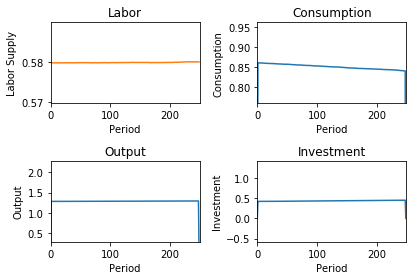

In [27]:
av_grid_l = np.mean( grid,axis=0)
av_grid_c = np.mean(Cgrid,axis=0)
av_grid_I = np.mean(Igrid,axis=0)
av_grid_O = np.mean(Ogrid,axis=0)

plt.subplot(221)
plt.tight_layout()
plt.plot(av_grid_l)
plt.axis([0,250,lbar-0.01,lbar+0.01])
plt.title("Labor")
plt.xlabel("Period")
plt.ylabel("Labor Supply")

plt.subplot(222)
plt.tight_layout()
plt.plot(av_grid_c)
plt.axis([0,250,consumption(kbar,lbar,wbar,rbar,paramss)-0.1,consumption(kbar,lbar,wbar,rbar,paramss)+0.1])
plt.title("Consumption")
plt.xlabel("Period")
plt.ylabel("Consumption")

plt.subplot(223)
plt.tight_layout()
plt.plot(av_grid_O)
plt.axis([0,250,outputs(kbar,lbar,paramss)-1,outputs(kbar,lbar,paramss)+1])
plt.title("Output")
plt.xlabel("Period")
plt.ylabel("Output")

plt.subplot(224)
plt.tight_layout()
plt.plot(av_grid_I)
plt.axis([0,250,investment(kbar,lbar,paramss)-1,investment(kbar,lbar,paramss)+1])
plt.title("Investment")
plt.xlabel("Period")
plt.ylabel("Investment")

plt.show()

## Question 8

We begin by creating a list of each calculation grid:

In [32]:
Lgrid = grid[:,:,1]
gridlist = np.array([Lgrid,Cgrid,Ogrid,Igrid])
grid_names_8 = np.array(["Labor Supply","Consumption","Output","Investment"])

print("----------------------------------------------------------------------------")
for node in range(len(gridlist)):
    print("--- Values for",grid_names_8[node], "Across",N,"Simulations ---")
    print("     ")
    
    A = np.mean(gridlist[node],axis=0)
    print("Mean                      :",A.mean())
    print("Std. Error                :",st.sem(A))
    print("     ")
    
    B = np.std(gridlist[node][1:],axis=0)
    print("Volatility                :", B.mean())
    print("Std. Error                :", st.sem(B))
    print("     ")
    
    t_grid = gridlist[node]
    C = np.mean(t_grid[:,1:-1],axis=0)/np.std(t_grid[:,1:-1],axis=0)
    print("Coefficient of Volatility :",C.mean())
    print("Std. Error                :",st.sem(C))
    print("     ")
    
    D = (np.mean(t_grid[:,1:-1],axis=0)/np.std(Ogrid[:,1:-1],axis=0))
    print("Relative Volatility       :",D.mean())
    print("St. Error                 :",st.sem(D))
    print("     ")
    
    E = np.ones(per)
    for i in range(per):
        E[i] = np.correlate(t_grid[:,i],t_grid[:,i])
    print("Persistence               :",E.mean())
    print("Std. Error                :",st.sem(E))
    print("      ")
    
    F = np.ones(per)
    for i in range(per):
        F[i] = np.correlate(t_grid[:,i],Ogrid[:,i])
    print("Cyclicality               :",F.mean())
    print("Std. Error                :",st.sem(F))
    print("      ")
    
    print("----------------------------------------------------------------------------")

----------------------------------------------------------------------------
--- Values for Labor Supply Across 10000 Simulations ---
     
Mean                      : 0.57985992898
Std. Error                : 4.41238784284e-06
     
Volatility                : 0.00798222544176
Std. Error                : 0.000180083911567
     
Coefficient of Volatility : 91.5775427081
Std. Error                : 4.43265803711
     
Relative Volatility       : 30.6504604805
St. Error                 : 18.8522620663
     
Persistence               : 3363.09328147
Std. Error                : 0.07525442622
      
Cyclicality               : 7404.37876228
Std. Error                : 42.1488184696
      
----------------------------------------------------------------------------
--- Values for Consumption Across 10000 Simulations ---
     
Mean                      : 0.844078072539
Std. Error                : 0.00481710425357
     
Volatility                : 0.0293280047823
Std. Error                : 0.

## Exercise 9

In [33]:
n1,n2 = 6,41
shock = np.zeros((n1,n2))
k = np.zeros(n2)
shock[0,0],shock[1,0],shock[2,0]=0,0,0

for i in range(1,n2):
    shock[0,i] = rho**i* sigma_z
    shock[1,i] = P6[0,0]*shock[1,i - 1] + Q6[0,0]*shock[0,i]
    shock[2,i] = P6[1,0]*shock[1,i - 1] + Q6[1,0]*shock[0,i]
shock[1,:] = kbar*np.exp(shock[1, :])
shock[2,:] = lbar*np.exp(shock[2, :])
w = wage_iter(shock[1,:], shock[2,:], shock[0,:])
r = rate_iter(shock[1,:], shock[2,:], shock[0,:])

for i in range(n2-1):
    shock[3,i] = shock[1,i] ** alpha * shock[1,i] ** (1 - alpha)
    shock[4,i] = shock[1,i + 1] - (1 - delta) * shock[1,i]
    shock[5,i] = w[i] * shock[2,i] + (r[i] - delta) * shock[1,i] + shock[1,i] - shock[1,i+1]

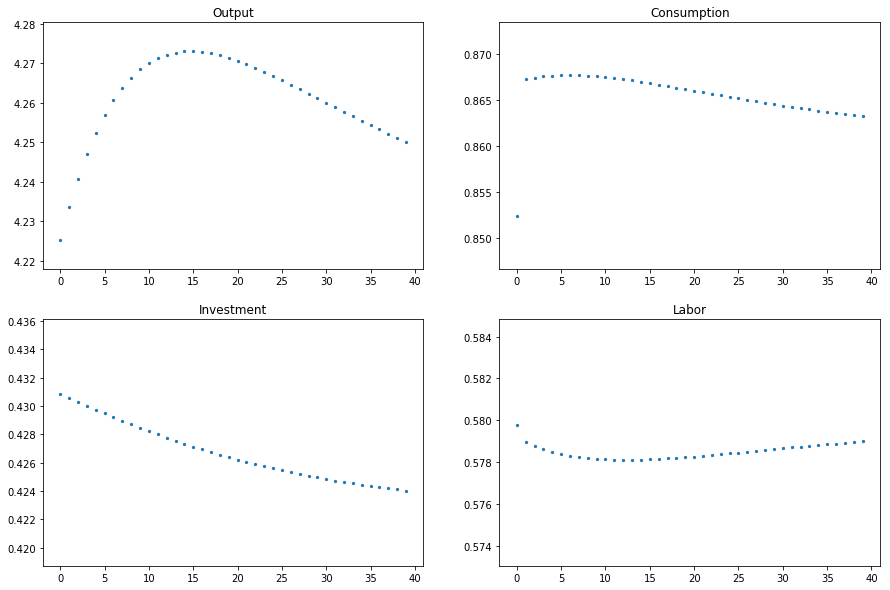

In [34]:
plt.figure(figsize=(15,10))

plt.subplot(221)
plt.scatter(np.arange(0,n2-1),shock[3,:][0:n2-1],s = 5)
plt.title("Output")

plt.subplot(222)
plt.scatter(np.arange(0,n2-1),shock[5,:][0:n2-1],s = 5)
plt.title("Consumption")

plt.subplot(223)
plt.scatter(np.arange(0,n2-1),shock[4, :][0: n2-1],s = 5)
plt.title("Investment")

plt.subplot(224)
plt.scatter(np.arange(0,n2-1),shock[2,:][0:n2-1],s = 5)
plt.title("Labor")


plt.show()

## Exercise 10

We begin by using the same techniques displayed above, but used to solve a heterogeneous OLG model. First parameterization and building the Euler equations:

In [41]:
alpha = 0.35
beta = 0.442
delta = 0.6415
rho_z = 0.9**20
sigma = 3.0
A = 1.0
zbar = 0 
T = 30

def Euler_OLG_10(Theta,params):
    (k2pp,k3pp,k2p,k3p,k2,k3,Zp,Z) = Theta
    alpha,delta,beta,gamma,sigma = params
    
    K,Kp = k2+k3,k2p+k3p
    L = 2.2
    w,wp = (1-alpha)*np.exp(Z)*((K/L)**alpha),(1-alpha)*np.exp(Zp)*((Kp/L)**alpha)
    r,rp = alpha*np.exp(Z)*((L/K)**(1-alpha))-delta,alpha*np.exp(Zp)*((L/Kp)**(1-alpha))-delta
    c1,c2 = (w - k2p),(w + (1+r)*k2-k3p)
    c2p,c3p = (wp + (1+rp)*k2p-k3pp),(wp*0.2 + (1+rp)*k3p)
    error1 = c1**(-sigma)-beta*(1+rp)*(c2p**(-sigma))
    error2 = c2**(-sigma)-beta*(1+rp)*(c3p**(-sigma))
    return np.array([error1, error2])

In [44]:
Zbar = np.array([zbar])
params = (alpha, delta, beta, gamma, sigma)
k2bar,k3bar = 0.019313,0.058411
theta0 = np.array([k2bar, k3bar, k2bar, k3bar, k2bar, k3bar, 0, 0])
[A1,B1,C1,D1,F1,G1,H1,J1,K1,L1,M1,W1,T1] = LinApp_Deriv(Euler_OLG_10, params, theta0, 2, 0, 1, logX=True)
N1 = rho_z
print("F :", F1)
print("G :", G1)
print("H :", H1)
print("L :", L1)
print("M :", M1)
print("N :", N1)

P1,Q1,U1,R1,S1,V1 = LinApp_Solve(A1,B1,C1,D1,F1,G1,H1,J1,K1,L1,M1,W1,T1,N1,Zbar,Sylv=1)
print ("P :",P1)
print ("Q :", Q1)

F : [[   0.         -137.01229779]
 [   0.            0.        ]]
G : [[ 249.94557984  128.12373087]
 [ -18.84397214  306.29076538]]
H : [[ -47.29041949 -143.02701252]
 [-115.81426991  -37.51653895]]
L : [[ 468.1055706 ]
 [ 200.17492121]]
M : [[-546.59716926]
 [-405.72547218]]
N : 0.12157665459056935
Sylvester equation solver condition is not satisfied; proceed with the original method...
P : [[ 0.03532165  0.63635524]
 [ 0.38029181  0.16163726]]
Q : [[ 1.86128493]
 [ 1.35969779]]


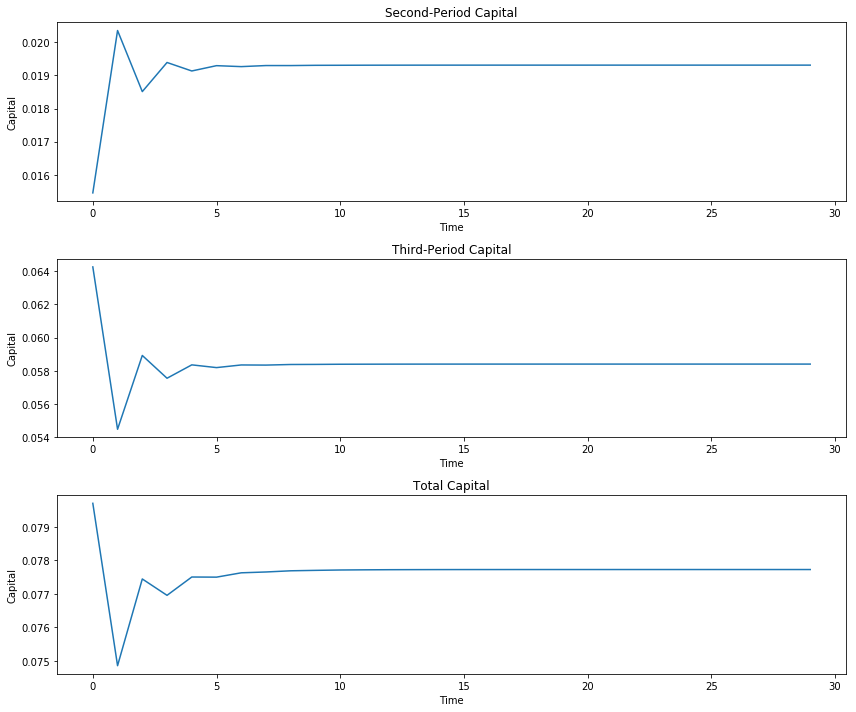

In [43]:
grid = np.zeros((2,T))
grid[0,0],grid[1,0] = np.log(0.8*k2bar)-np.log(k2bar),np.log(1.1*k3bar)-np.log(k3bar)
for t in range(1,T):
    grid[:,t] = (P1 @ grid[:,t-1])
grid = np.array([[k2bar],[k3bar]])*np.exp(grid)
Kgrid = np.sum(grid,axis=0)

plt.figure(figsize=(12,10))
plt.subplot(311)
plt.plot(np.arange(T),grid[0,:])
plt.title('Second-Period Capital')
plt.xlabel('Time')
plt.ylabel('Capital')
plt.tight_layout()

plt.subplot(312)
plt.plot(np.arange(T),grid[1,:])
plt.title('Third-Period Capital')
plt.xlabel('Time')
plt.ylabel('Capital')
plt.tight_layout()

plt.subplot(313)
plt.plot(np.arange(T),Kgrid)
plt.title('Total Capital')
plt.xlabel('Time')
plt.ylabel('Capital')
plt.tight_layout()

plt.show()

## Exercise 11